## Loading and extraction of the dataset

In [1]:
run_id = 14 #two classes mito and cyto removed
run_id = 13 #Just 3 classes
run_id = 15
run_id = 6  #Just mito

In [2]:
#Taken from https://github.com/okraus/DeepLoc/blob/master/download_datasets.sh
import os
if not (os.path.exists('datasets/Chong_train_set.hdf5')):
    !curl http://spidey.ccbr.utoronto.ca/~okraus/DeepLoc_full_datasets.zip --output DeepLoc_full_datasets.zip
    !unzip DeepLoc_full_datasets.zip
    !rm DeepLoc_full_datasets.zip
!ls -lh datasets

total 3.2G
-rw-r--r-- 1 root root 153M Jan  7  2017 Chong_test_set.hdf5
-rw-r--r-- 1 root root 738M Jan  7  2017 Chong_train_set.hdf5
-rw-r--r-- 1 root root 152M Jan  7  2017 Chong_valid_set.hdf5
-rw-r--r-- 1 root root  740 Jan  8  2017 README.TXT
-rw-r--r-- 1 root root  46M Jan  8  2017 Schuldiner_test_set.hdf5
-rw-r--r-- 1 root root 405M Jan  8  2017 Schuldiner_train_set.hdf5
-rw-r--r-- 1 root root 172M Jan  8  2017 wt2017_test_set.hdf5
-rw-r--r-- 1 root root 1.5G Jan  8  2017 wt2017_train_set.hdf5


In [3]:
import numpy as np
import h5py
fn1 = 'datasets/Chong_train_set.hdf5'
d1 = h5py.File(fn1)
print(list(d1.keys()))
l = [d for d in zip(np.argmax(d1['Index1'],axis=1), d1['label_names'])]
from collections import Counter
Counter(l)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['Index1', 'Info1', 'data1', 'label_names']


Counter({(0, b'ACTIN'): 738,
         (1, b'BUDNECK'): 535,
         (2, b'BUDTIP'): 336,
         (3, b'CELLPERIPHERY'): 423,
         (4, b'CYTOPLASM'): 1500,
         (5, b'ENDOSOME'): 1500,
         (6, b'ER'): 1500,
         (7, b'GOLGI'): 1500,
         (8, b'MITOCHONDRIA'): 1500,
         (9, b'NUCLEARPERIPHERY'): 1500,
         (10, b'NUCLEI'): 1500,
         (11, b'NUCLEOLUS'): 1500,
         (12, b'PEROXISOME'): 988,
         (13, b'SPINDLE'): 185,
         (14, b'SPINDLEPOLE'): 1500,
         (15, b'VACUOLARMEMBRANE'): 1500,
         (16, b'VACUOLE'): 1500,
         (17, b'DEAD'): 749,
         (18, b'GHOST'): 1428})

In [4]:
# run_desc = 'kraus1_full_no_batch_no_myto'
# myto_idx = 8
# num_classes = 18

In [5]:
import tensorflow as tf
import keras


from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Flatten, Activation
from keras.layers import Lambda, Dropout, BatchNormalization, Convolution2D, MaxPooling2D
from keras import initializers
from keras.optimizers import Adam, RMSprop
from keras.utils import to_categorical
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16, preprocess_input

from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.contrib.keras.python.keras.layers.merge import Concatenate
# from tensorflow.contrib.keras.python.keras.layers import Lambda, RepeatVector

import h5py
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
%matplotlib inline
#('1.6.0', '2.1.5', '1.14.2', '2.7.1')
tf.__version__,keras.__version__, np.__version__, h5py.__version__

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


('1.6.0', '2.1.5', '1.14.1', '2.7.1')

In [6]:
def flatBatch2Tensor(batchData,imSize,channels):
    splitByChannel = [batchData[:,(chan*imSize**2):((chan+1)*imSize**2)].reshape((-1,imSize,imSize,1)) \
                      for chan in range(channels)]
    tensorBatchData = np.concatenate(splitByChannel,3)
    return tensorBatchData

def load_kraus():
       
    #fn1 = 'datasets/wt2017_train_set.hdf5'
    #fn2 = 'datasets/wt2017_test_set.hdf5'
    
    fn1 = 'datasets/Chong_train_set.hdf5'
    fn2 = 'datasets/Chong_test_set.hdf5'
    fn3 = 'datasets/Chong_valid_set.hdf5'
    d1 = h5py.File(fn1)
    d2 = h5py.File(fn2)
    d3 = h5py.File(fn3)
    
    X_train = flatBatch2Tensor(d1['data1'][:], 64, 2)
    X_test = flatBatch2Tensor(d2['data1'][:], 64, 2)
    X_valid = flatBatch2Tensor(d3['data1'][:], 64, 2)
    y_train = d1['Index1'][:]
    y_test = d2['Index1'][:]
    y_valid = d3['Index1'][:]
    
    # We bring the data into the range [0,1] and clamp it due to heavy outliers
    X_train = np.clip(X_train,0,100)/100
    X_test = np.clip(X_test,0,100)/100
    X_valid = np.clip(X_valid,0,100)/100
    
    # For sparse labels
    #y_train = np.ndarray.astype(np.argmax(d1['Index1'],axis=1),'int32')
    #y_test = np.ndarray.astype(np.argmax(d2['Index1'],axis=1),'int32')
        
    print("X_train type {} dtype {} shape {}".format(type(X_train), X_train.dtype,np.shape(X_train)))
    print("X_train min {}, max {} mean {}".format(np.min(X_train), np.max(X_train), np.mean(X_train)))
    print("Y_train shape {} Y_test shape{} Y_validation shape{} ".format(np.shape(y_train), np.shape(y_test), np.shape(y_valid)))
    return X_train, y_train, X_test, y_test, X_valid, y_valid

In [7]:
import h5py
import numpy as np
X_train, Y_train, X_test, Y_test, X_valid, Y_valid = load_kraus()

X_train type <class 'numpy.ndarray'> dtype float32 shape (21882, 64, 64, 2)
X_train min 0.0, max 1.0 mean 0.17277522385120392
Y_train shape (21882, 19) Y_test shape(4516, 19) Y_validation shape(4491, 19) 


In [8]:
y_train = np.argmax(Y_train,axis=1)
y_valid = np.argmax(Y_valid,axis=1)
y_test = np.argmax(Y_test,axis=1)

y_max = np.max(y_train) #0,...
num_class_org = y_max + 1
print('Number of classes ', num_class_org, '   from', 0, 'to', y_max)

Number of classes  19    from 0 to 18


### Removing classes and fixing directories

In [9]:
if run_id == 14:
    myto_idx = 8
    keep_idx = list(np.linspace(start=0,stop=y_max,num=y_max+1, dtype='int32'))
    keep_idx.remove(myto_idx)
    keep_idx.remove(5)
elif run_id == 6: ## For myto
    myto_idx = 8
    keep_idx = list(np.linspace(start=0,stop=y_max,num=y_max+1, dtype='int32'))
    keep_idx.remove(myto_idx)
elif run_id == 13: ##All but 
    keep_idx = list((5,6,8))
elif run_id == 15: ##All but 
    keep_idx = list(range(0, 10))
else:
    print("!!! ------ wrong run id ---")

num_classes = len(keep_idx)
print("Number of classes (after cutting)" , num_classes, "to keep from org", keep_idx)

Number of classes (after cutting) 18 to keep from org [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


In [10]:
all_to_limited = dict()
limited_to_all = dict()
c = 0
for i in range(num_class_org):
    all_to_limited[i] = c
    limited_to_all[c] = i
    if (keep_idx.count(i) > 0):
      c += 1
    else: #not in 
      all_to_limited[i] = -1
      
#all_to_limited
#limited_to_all

In [11]:
keep_training = [keep_idx.count(y) > 0 for y in y_train]
X_train_keep = X_train[keep_training]
y_train_keep = [all_to_limited[y] for y in y_train if keep_idx.count(y) > 0] 

keep_valid = [keep_idx.count(y) > 0 for y in y_valid]
X_valid_keep = X_valid[keep_valid]
y_valid_keep = [all_to_limited[y] for y in y_valid if keep_idx.count(y) > 0] 

# Translate to the new data, if -1 then not in the training set
y_test_translated = [all_to_limited[y] for y in y_test]

X_train_keep.shape, X_valid_keep.shape, len(np.unique(y_train_keep)),np.sum([1 for y  in y_test_translated if y > 0])

((20382, 64, 64, 2), (3849, 64, 64, 2), 18, 3780)

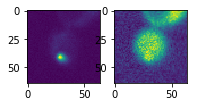

In [12]:
num = 20381
plt.subplot(1,4,1)
plt.imshow(X_train_keep[len(X_train_keep)-1,:,:,0])
plt.subplot(1,4,2)
plt.imshow(X_train_keep[len(X_train_keep)-1,:,:,1])

## Loading of the model

In [13]:
tf.reset_default_graph()
sess = tf.Session()
K.set_session(sess)
if False: #In the google  cloud
    # Model only with Mito
    #!curl -kL https://www.dropbox.com/s/cta6woqwg4ig1hf/final.keras_006.model?dl=1 --output final.keras.model

    # Model learned from the classes: "Endo, Er, Mito "
    !curl -kL https://www.dropbox.com/s/1eqkz20mxngxr7f/final.keras.013.model?dl=1 --output final.keras.model
    
    # Load via browser
    # from google.colab import files

    # uploaded = files.upload()

    # for fn in uploaded.keys():
    #   print('User uploaded file "{name}" with length {length} bytes'.format(
    #       name=fn, length=len(uploaded[fn])))
 
    model = load_model('final.keras.model')
else:
    if run_id == 14:
        model = load_model('results_bayes/014-chong_no_batch_only_EndoErMito/final.keras.model')
    elif run_id == 13:
        model = load_model('results_bayes/013-chong_no_batch_only_EndoErMito/final.keras.model')
    elif run_id == 6:
        model = load_model('results_bayes/006-kraus1_full_no_batch_no_myto/final.keras.model')
    elif run_id == 15:
        model = load_model('results_bayes/015-chong_no_batch_only_EndoErMito/final.keras.model')
print(model.summary())
model.input_shape, model.output_shape

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        608       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 32)        0         
__________

((None, 64, 64, 2), (None, 18))

## Preditions no mc-dropout

In [14]:
import pandas
preds_test_classical = model.predict_proba(X_test)

df = pandas.DataFrame(
        columns=['cell_id','true_label','pred_label','confidence', 'method', 'mc_dropout', 'run_id'])

mc_dropout = False
run_length = len(X_test)

for j in range(run_length):
    k = np.argmax(preds_test_classical[j])
    p_k = np.max(preds_test_classical[j])
    df.loc[j] = [j, y_test_translated[j],k, p_k, 'max_p', mc_dropout,run_id]

df.to_csv("{}_nomc.csv".format(run_id))

In [15]:
print(np.average(df['true_label'] == df['pred_label']))
df[0:5]

0.8033658104517272


,cell_id,true_label,pred_label,confidence,method,mc_dropout,run_id
0,0,6,6,0.720276,max_p,False,6
1,1,15,15,0.999994,max_p,False,6
2,2,8,8,0.999975,max_p,False,6
3,3,1,1,0.999999,max_p,False,6
4,4,14,14,0.999999,max_p,False,6


#### All probabilities no dropout

In [30]:
pks = model.predict_proba(X_test)
text_header = ["p_nomc_test{}".format(i+1) for i in range(0,pks.shape[1])]
np.savetxt("{}_probs_no_mc.csv".format(run_id), pks, fmt='%5s',delimiter=",")

## Activating the dropout and testing it

In [16]:
def make_dropout_batch(x):
    size = 100
    return tf.tile(x,[size,1,1,1])

In [17]:
inputs = Input(shape=(64,64,2))
x0 = Lambda(make_dropout_batch, name='replication')(inputs)
for layer in model.layers:
     #print(layer.name)
     x0 = layer(x0)
model2 = Model(inputs, x0)

In [18]:
np.std(model.predict_proba(X_train_keep[0:200])) #Correct keras call

0.22356957

In [19]:
lp = sess.graph.get_tensor_by_name('dropout_1/keras_learning_phase:0')

In [20]:
res = sess.run(model.output, {model.input:X_train_keep[0:200],lp:0}) # No Dropout
np.std(res), np.mean(np.argmax(res,axis=1) == y_train_keep[0:200])#Same result

(0.22356957, 0.975)

In [21]:
# Doing mc-dropout but with a single run ==> preformance is degenerated
for _ in range(5):
    res = sess.run(model.output, {model.input:X_train_keep[0:200],lp:1}) # Dropout at test time
    print(np.mean(np.argmax(res,axis=1) == y_train_keep[0:200]))

0.955
0.97
0.96
0.97
0.96


In [22]:
# model 2 does many dropout runs 
acc = 0
for i in range(200):
  res = sess.run(model2.output, {model2.input:X_train_keep[i:i+1],lp:1})
  acc += np.argmax(np.mean(res,axis=0)) == y_train_keep[i:i+1][0]
acc / 200

0.995

## Doing the dropout runs

In [23]:
df = pandas.DataFrame(
        columns=['cell_id','true_label','pred_label','confidence', 'method', 'mc_dropout', 'run_id'])

mc_dropout = True
for i in range(len(X_test)):
    res = sess.run(model2.output, feed_dict={model2.input:X_test[i:i+1], lp:1}) #On image many MC-runs
    pk = np.mean(res, axis=0)
    k = np.argmax(pk)
    sigma = np.sqrt(np.sum(np.var(res, axis=0)))
    entropy = -np.sum(pk * np.log2(pk + 1E-14)) #Numerical Stability

    classes = np.argmax(res,axis=1)
    counts = np.bincount(classes)
    k_counts = np.argmax(counts)
    rel_freq = counts[k_counts]/len(classes)
    # change: statt pk[k] nun pk, da prob von allen Klassen gebraucht werden
    # bei indices immer + (len(pk) -1)
    df.loc[4*i + (len(pk) -1) ] = [i, y_test_translated[i],k, pk, 'mean_p', mc_dropout,run_id]
    df.loc[4*i + (len(pk) -1) + 1] = [i, y_test_translated[i],k, sigma, 'mean_sigma', mc_dropout,run_id]
    df.loc[4*i + (len(pk) -1) + 2] = [i, y_test_translated[i],k, entropy, 'mean_entropy', mc_dropout,run_id]
    df.loc[4*i + (len(pk) -1) + 3] = [i, y_test_translated[i],k_counts, rel_freq, 'counts_relfreq', mc_dropout,run_id]

    if (i < 2 or i % 100 == 0):
        print(i,' / ', run_length)

df.to_csv("{}_mc_all_classes.csv".format(run_id))

0  /  4516
1  /  4516
100  /  4516
200  /  4516
300  /  4516
400  /  4516
500  /  4516
600  /  4516
700  /  4516
800  /  4516
900  /  4516
1000  /  4516
1100  /  4516
1200  /  4516
1300  /  4516
1400  /  4516
1500  /  4516
1600  /  4516
1700  /  4516
1800  /  4516
1900  /  4516
2000  /  4516
2100  /  4516
2200  /  4516
2300  /  4516
2400  /  4516
2500  /  4516
2600  /  4516
2700  /  4516
2800  /  4516
2900  /  4516
3000  /  4516
3100  /  4516
3200  /  4516
3300  /  4516
3400  /  4516
3500  /  4516
3600  /  4516
3700  /  4516
3800  /  4516
3900  /  4516
4000  /  4516
4100  /  4516
4200  /  4516
4300  /  4516
4400  /  4516
4500  /  4516


In [ ]:
# from google.colab import files
# files.download('EndoErMito_mcdropout_013.csv')